### Prepare the library


In [ ]:
import os
import pandas as pd
import numpy as np
import math, os, sys
import itertools
import imageio

from __future__ import absolute_import, division, print_function, unicode_literals
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('default')

!pip install scikit-image
from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize
from scipy import ndimage

!pip install tensorflow
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

### Accessing the file


In [ ]:
!ls image
!ls image/train
!ls image/train/dry
!ls image/train/normal
!ls image/train/oily

_We test whether the image can be read._


In [ ]:
image = imageio.imread("image/train/oily/oily33.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [5]:
IMAGE_SIZE = 224
BATCH_SIZE = 128
base_dir = os.path.join('image/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset ='validation')

Found 336 images belonging to 3 classes.
Found 84 images belonging to 3 classes.


In [6]:
X_test = []
y_test = []

for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if not os.path.isdir(folder_path):
        continue

    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)

        image = tf.keras.preprocessing.image.load_img(image_path)
        image = tf.keras.preprocessing.image.img_to_array(image) / 255.
        image = tf.image.resize(image, (224, 224))
        X_test.append(image)

        category = os.path.split(folder)[-1]
        y_test.append(category)

In [7]:
X_test = np.array(X_test)
y_test = np.array(y_test)

for image_batch, label_batch in train_generator:
    break
print("Train Shape:", image_batch.shape, label_batch.shape)

for image_batch, label_batch in val_generator:
    break

print("Validation Shape:", image_batch.shape, label_batch.shape)
print("Test Shape:", X_test.shape, y_test.shape)

Train Shape: (128, 224, 224, 3) (128, 3)
Validation Shape: (84, 224, 224, 3) (84, 3)
Test Shape: (420, 224, 224, 3) (420,)


In [8]:
print (train_generator.class_indices)

labels_txt= '\n'.join(sorted (train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
    f.write(labels_txt)

{'dry': 0, 'normal': 1, 'oily': 2}


_Using a MobileNet to architecture from TensorFlow's Keras applications module._


In [9]:
IMG_SHAPE = (224, 224, 3)
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                             include_top = False,
                                             weights = 'imagenet')

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [11]:
label_to_index = {'dry': 0, 'normal': 1, 'oily': 2}

y_test_numeric = [label_to_index[label] for label in y_test]
y_test2 = to_categorical(y_test_numeric, num_classes = 3)
X_test3, y_test3 = X_test, y_test2

print("y_test2 (one-hot encoded labels):\n", y_test2[:10])
print("X_test3 shape:", X_test3.shape)
print("y_test3 shape:", y_test3.shape)

y_test2 (one-hot encoded labels):
 [[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
X_test3 shape: (420, 224, 224, 3)
y_test3 shape: (420, 3)


### Sets up a convolutional neural network (CNN) using a pre-trained MobileNet model as the base


In [12]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers. Dense(3, activation ='softmax')
    ])

model.compile("adam", loss="categorical_crossentropy", metrics = ["acc"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 5, 5, 32)            │         294,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,523,907 (13.44 MB)

 Trainable params: 295,043 (1.13 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

### Starting to running train

We will train the model for 20 epochs.


In [13]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 43s 10s/step - acc: 0.3544 - loss: 3.0051 - val_acc: 0.3333 - val_loss: 2.4327
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - acc: 0.4422 - loss: 1.4424 - val_acc: 0.3810 - val_loss: 0.9972
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step - acc: 0.4104 - loss: 0.9707 - val_acc: 0.4643 - val_loss: 0.9479
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - acc: 0.6259 - loss: 0.9025 - val_acc: 0.7738 - val_loss: 0.9076
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step - acc: 0.7280 - loss: 0.8597 - val_acc: 0.7857 - val_loss: 0.8201
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 8s/step - acc: 0.7478 - loss: 0.7618 - val_acc: 0.8452 - val_loss: 0.6143
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 9s/step - acc: 0.8492 - loss: 0.5727 - val_acc: 0.8214 - val_loss: 0.5270
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step - acc: 0.8441 - loss: 0.4643 - val_acc: 0.8690 - val_loss: 0.4086
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 8s/step - acc: 0.8850 - loss: 0.3486 - val_acc: 0.9167 - v

_We can display a diagram to visualize the progress of the training over 20 epochs._


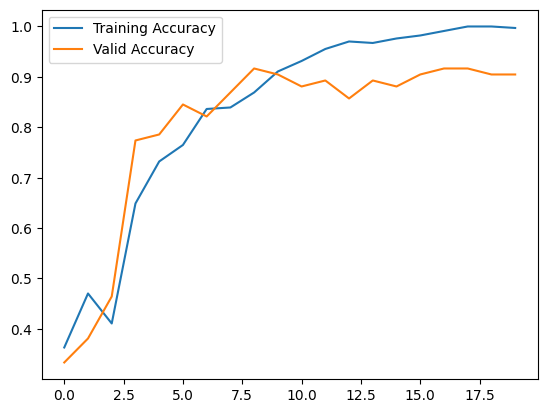

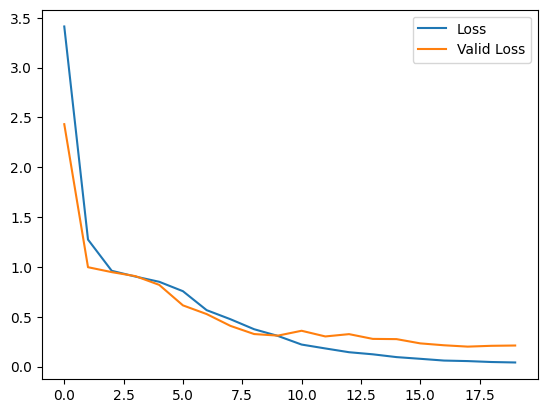

In [14]:
plt.plot(history.history["acc"], label="Training Accuracy")
plt.plot(history.history["val_acc"], label = "Valid Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Valid Loss")
plt.legend()
plt.show()

In [15]:
print(train_generator)

We will start by testing the model on the array to evaluate its accuracy.


In [16]:
n = 44
input_image = image_batch[n][np.newaxis,...]
print("Label: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediction: ", predictions[0])

Label:  [0. 1. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction:  [0.00314869 0.9887645  0.00808677]


In [17]:
print(model.metrics_names)
print(model.evaluate(x= X_test3, y = y_test3))

['loss', 'compile_metrics']
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - acc: 0.9891 - loss: 0.0707
[0.07028404623270035, 0.9857142567634583]


In [18]:
y_true = np.argmax(y_test2,axis=1)
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

After that, we will test the predictions with visual output to see if they match our expectations.


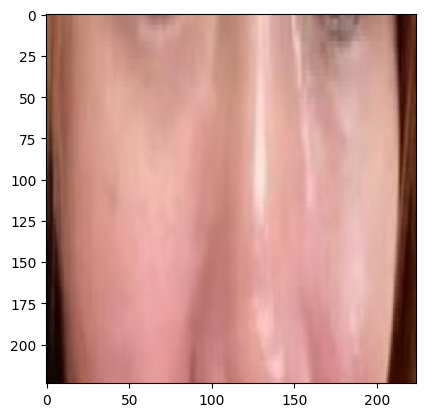

True Label: 2 : oily
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Value: [0.00217501 0.005817   0.992008  ]
Prediciton Label: 2 : oily
Prediction Correct!
Recommendation: For oily skin, use skincare products containing Salicylic Acid, Beta Hydroxy Acid (BHA), Kaolin Clay, and Tea Tree Oil.


In [19]:
n = 195 #test
labels = ['dry', 'normal', 'oily']

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2, axis=1) [n]
print("True Label:", true_label,":", labels[true_label])
prediction = model.predict(X_test[n][ np.newaxis,...]) [0]
print("Value:", prediction)
predicted_label = np.argmax(prediction)
print("Prediciton Label:", predicted_label,":", labels[predicted_label])

if true_label == predicted_label:
    print("Prediction Correct!")

else:
    print("Prediction incorrect!")

if predicted_label == 0:
    recommendation = "Recommendation: For dry skin, use skincare products containing Essential Acid, Hyaluronic Acid, and Vitamin E."
elif predicted_label == 1:
    recommendation = "Recommendation: For normal skin, use skincare products containing Hyaluronic Acid and Phyto-Retinol."
elif predicted_label == 2:
    recommendation = "Recommendation: For oily skin, use skincare products containing Salicylic Acid, Beta Hydroxy Acid (BHA), Kaolin Clay, and Tea Tree Oil."
else:
    recommendation = "Recommendation is not available for this skin type."

print(recommendation)


### This visualization provides a matrix diagram to visually display the accuracy.


Normalized confusion matrix
[[0.99 0.   0.01]
 [0.   1.   0.  ]
 [0.   0.04 0.96]]
              precision    recall  f1-score   support

         dry       1.00      0.99      1.00       140
      normal       0.97      1.00      0.98       140
        oily       0.99      0.96      0.98       140

    accuracy                           0.99       420
   macro avg       0.99      0.99      0.99       420
weighted avg       0.99      0.99      0.99       420



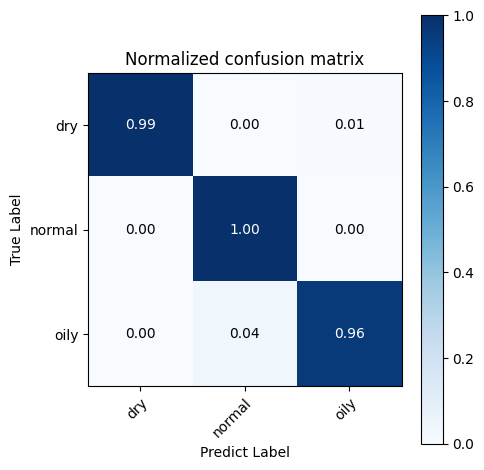

In [20]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True Label',
           xlabel='Predict Label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)
plot_confusion_matrix(y_true, y_pred, classes=np.array(labels), normalize=True,
                      title='Normalized confusion matrix')

print(classification_report(y_true, y_pred, target_names=labels))

After confirming that the model's output meets our expectations, we will save it in the .h5 format.


In [21]:
model.save('modelku.h5')

In [22]:
loaded_model = tf.keras.models.load_model('modelku.h5')
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 5, 5, 32)            │         294,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,523,909 (13.44 MB)

 Trainable params: 295,043 (1.13 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

 Optimizer params: 2 (12.00 B)

After saving the model in the .h5 format, we will convert and save it in the .tflite format for deployment in a mobile app.


In [ ]:
saved_model_dir ='model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Klasifikasi_Jenis_Kulit_Wajah_MobileNet_Baru.tflite', 'wb') as f:
    f.write(tflite_model)